In [118]:
import json
import glob
import os
import re
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from nltk.util import ngrams 
from spacymoji import Emoji

nlp = spacy.load('it_core_news_sm')
nlp.add_pipe("emoji", first=True)
_data_path = "./data/"
video_ids_file = _data_path + "video_list.csv"

In [8]:
df = pd.read_csv(video_ids_file)
df = df.fillna("")
df["id"] = [re.sub("video/", "", re.findall("video/[0-9]{19}", link)[0]) for link in df["Link"]]
df["name"] = np.where(df["Politician"]=="", df["Influencer/tiktoker"].replace(" ", "_", regex=True), df["Politician"].replace(" ", "_", regex=True))
df["file"] = _data_path + df['name'] + "_com_" + df["id"] + ".json"

df.head(5)

,Influencer/tiktoker,Politician,Date,Subject,Link,Done,id,name,file
0,,Meloni,19/09/2022,RDC,https://www.tiktok.com/@giorgiameloni_ufficial...,False,7144986246215929094,Meloni,./data/Meloni_com_7144986246215929094.json
1,,Salvini,23/09/2022,Renewable energy,https://www.tiktok.com/@matteosalviniufficiale...,False,7146104387079900421,Salvini,./data/Salvini_com_7146104387079900421.json
2,,Berlusconi,02/09/2022,Young generation,https://www.tiktok.com/@silvio.berlusconi/vide...,False,7138834940187151622,Berlusconi,./data/Berlusconi_com_7138834940187151622.json
3,Arianna Biella,,08/09/2022,Personal preferences on proposed issues,https://www.tiktok.com/@ariannabiellas/video/7...,False,7140954969871600901,Arianna_Biella,./data/Arianna_Biella_com_7140954969871600901....
4,Arianna Biella,,08/09/2022,Personal preferences on proposed issues,https://www.tiktok.com/@ariannabiellas/video/7...,False,7140961766028102918,Arianna_Biella,./data/Arianna_Biella_com_7140961766028102918....


In [55]:
dic = {}

for i, row in df.iterrows():
    if os.path.isfile(row["file"]):
        with open(row["file"]) as infile:
            comments = json.load(infile)
        dic[row["id"]] = {"raw_comments":comments["comments"], "meta":comments["meta"]}

In [56]:
for com in dic["7135099086641925381"]["raw_comments"]:
    print(com["text"])

solo Conte
@linda 🥥 @anna_guarato @Giorgia • seguila fidati @William Simonato CHIARAMENTE IL PROGRAMMA MIGLIORE, VOTATELO.
hanno il migliore programma ce poco da dire
riduzione del lavoro e così si da posto ad altri
Grazie per il tuo commento. A breve pubblicheremo il programma completo con molti più dettagli 👍
il MoVimento 5 Stelle non ha fatto cadere Draghi poiché nonostante avesse chiesto 9 punti, aveva lo stesso la maggioranza. Sono stati Lega e FI.
5 ⭐
Non capisco l’equazione più ore più produttività…a volte è proprio il contrario
Meno ore, meno stress, più energia e risultati.
hanno fatto degli studi, con la riduzione dell orario lavorativo aumenta la produttività
mi hai convinto voto Il presidente Conte
Produttività non significa necessariamente aumentare l'orario di lavoro. In alcuni paesi esteri che i dipendenti rendono molto di più lavorando meno
quindi se portiamo l'orario di lavoro a 16 ore raddoppiamo la produttività. 😂
Se andrò al voto consapevole è per il 90% merito tuo,

In [91]:
def clean_text(text, search_words):
    doc = nlp(text)

    bog = []

    for token in doc:

        # filter stopwords
        if not token.is_stop:
            # filter punctiation
            if not token.is_punct:
                if not token.like_url:
                    if not token.like_email:
                        if not token.is_space:
                            if token.lemma_ not in ['\n', ' ']:
                                # filter words used to search for tweets  
                                if token._.is_emoji:
                                    token.lemma_ = "[emoji]"
                                if str(token) not in search_words:
                                    bog.append(re.sub('@', '', token.lemma_))
                                
    
    return bog

        

In [95]:
search_words = ['@GiorgiaMeloni']
test_str = nlp("Questa, è una bellissima prova 😻 👍🏿 @GiorgiaMeloni")
clean_text(test_str, search_words)

['bellissimo', 'prova', '[emoji]', '[emoji]']

In [103]:
for key, video in dic.items():
    print(key)
    bog = []
    for com in video["raw_comments"]:
        bog.extend(clean_text(com["text"], search_words))
    dic[key]["bog"] = bog

7144986246215929094
7146104387079900421
7138834940187151622
7140954969871600901
7140961766028102918
7140966608507358470
7146956596566854918
7145502591374478597
7145499511735995653
7135099086641925381
7141021308854258950
7141759612398619910
7145760603284557062
7146121731453816070
7145164667416071429
7147574255566212358
7139123631396785413
7142138056961805573
7142568390882823430
7143180350783589637
7143561555014094085
7144267628167597318
7146675181451349253
7147292315554450693
7144246488879713542
7144023384853171462
7145360998407425285
7145435366529551621
7145754357013777670
7146526475439639814


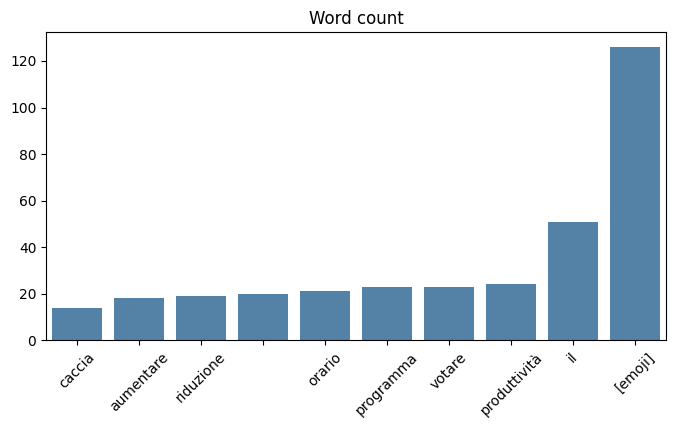

In [138]:
bog = dic["7135099086641925381"]["bog"]
vocab, word_count = np.unique(bog, return_counts=True)
top10 = np.argsort(word_count)[-10:]

# plot word counts
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=vocab[top10], y=word_count[top10], ax=ax, color='steelblue')
ax.set_title('Word count')
ax.tick_params(axis='x', labelrotation = 45)
plt.show()